In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [38]:
import matplotlib.pyplot as plt

# Example colors
cat_color = "#d0e1f9"      # light blue
num_color = "#f9d0d0"      # light red

fig, ax = plt.subplots(figsize=(10, 2.5))
ax.axis('off')

# Extract data
values = df.head(5).values
columns = df.columns

# Build table
table = ax.table(
    cellText=values,
    colLabels=columns,
    cellLoc='center',
    loc='center'
)

# Color columns
for (row, col), cell in table.get_celld().items():
    # Header row (row == 0)
    if row == 0:
        if col < 2:          # first two column headers
            cell.set_facecolor(cat_color)
        else:
            cell.set_facecolor(num_color)
    else:
        if col < 2:          # first two data columns
            cell.set_facecolor(cat_color)
        else:
            cell.set_facecolor(num_color)

plt.savefig("colored_table.png", dpi=300, bbox_inches='tight')
plt.close()

## Import Data


In [25]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df_full = pd.read_csv(url)

df = df_full[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].copy()
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


## Normalize the Features

In [26]:
X = StandardScaler().fit_transform(df)

## PCA Reduced data BEFORE Clustering

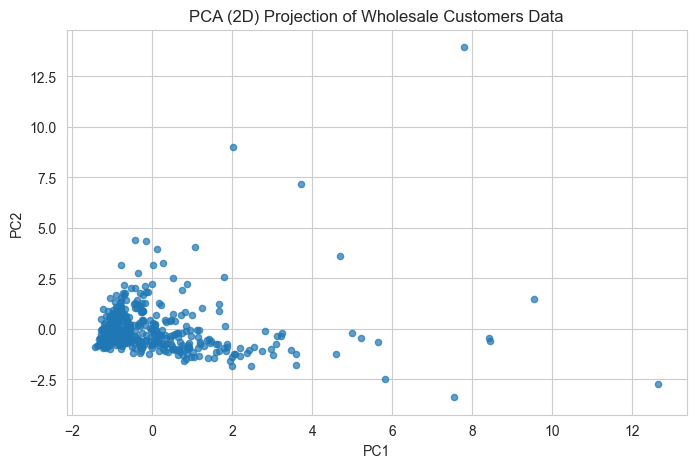

In [27]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=20, alpha=0.7)
plt.title("PCA (2D) Projection of Wholesale Customers Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## DBSCAN Clustering
### Choosing eps & min_samples:
    - eps controls neighborhood radius.
    - min_samples is min points required for a core point.

In [28]:
dbscan = DBSCAN(eps=0.6, min_samples=5)
labels = dbscan.fit_predict(X)

np.unique(labels)

array([-1,  0,  1,  2])

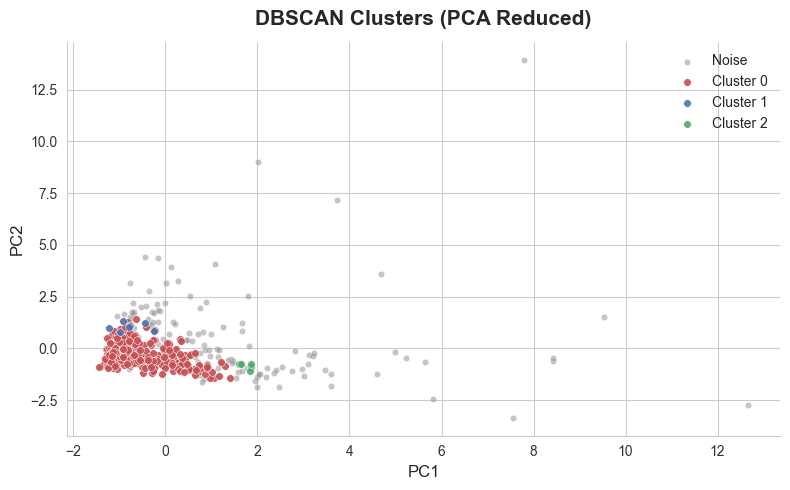

In [29]:
# Nature/Science-style palette
palette = ["#C44E52", "#4C72B0", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]

plt.figure(figsize=(8, 5))

# Plot each cluster separately for better control
for cluster_id in np.unique(labels):
    mask = labels == cluster_id
    if cluster_id == -1:
        # Noise points in gray
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c='#8C8C8C', s=20, alpha=0.5, 
                   edgecolor='white', linewidth=0.3,
                   label='Noise')
    else:
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=palette[cluster_id % len(palette)], 
                   s=30, alpha=0.9,
                   edgecolor='white', linewidth=0.4,
                   label=f'Cluster {cluster_id}')

plt.title("DBSCAN Clusters (PCA Reduced)", fontsize=15, weight='bold', pad=12)
plt.xlabel("PC1", fontsize=12)
plt.ylabel("PC2", fontsize=12)
plt.legend(frameon=False, fontsize=10)

# Minimalist styling
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_linewidth(0.8)
ax.spines["left"].set_linewidth(0.8)
ax.tick_params(colors="#333333", labelsize=10, length=3, width=0.8)

plt.tight_layout()
plt.show()

## Cluster Size Distribution

In [30]:
unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

# Create a nice table
sizes_df = pd.DataFrame(list(cluster_sizes.items()), 
                        columns=['Cluster', 'Size'])
sizes_df['Percentage'] = (sizes_df['Size'] / len(labels) * 100).round(2)
sizes_df = sizes_df.sort_values('Cluster')
sizes_df

,Cluster,Size,Percentage
0,-1,131,29.77
1,0,297,67.50
2,1,7,1.59
3,2,5,1.14


## Internal Clustering Metrics

**Note:** Metrics are calculated only on non-noise points (cluster != -1) as noise points don't belong to any cluster.

In [31]:
# Filter out noise points for metrics calculation
non_noise_mask = labels != -1
X_non_noise = X[non_noise_mask]
labels_non_noise = labels[non_noise_mask]

# Check if we have enough clusters for metrics
n_clusters = len(np.unique(labels_non_noise))

if n_clusters > 1:
    sil = silhouette_score(X_non_noise, labels_non_noise)
    dbi = davies_bouldin_score(X_non_noise, labels_non_noise)
    ch = calinski_harabasz_score(X_non_noise, labels_non_noise)
    
    metrics_data = {
        'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score'],
        'Value': [sil, dbi, ch],
        'Interpretation': [
            'Higher is better (range: -1 to 1)',
            'Lower is better (≥0)',
            'Higher is better'
        ]
    }
    
    metrics_df = pd.DataFrame(metrics_data)
    print(f"\nClustering Metrics (excluding {(~non_noise_mask).sum()} noise points):")
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of points in clusters: {len(labels_non_noise)}")
    print()
    display(metrics_df)
else:
    print(f"Warning: Only {n_clusters} cluster(s) found. Cannot calculate metrics.")
    print("Consider adjusting eps and min_samples parameters.")


Clustering Metrics (excluding 131 noise points):
Number of clusters: 3
Number of points in clusters: 309



,Metric,Value,Interpretation
0,Silhouette Score,0.379401,Higher is better (range: -1 to 1)
1,Davies-Bouldin Index,0.537826,Lower is better (≥0)
2,Calinski-Harabasz Score,36.238526,Higher is better



DBSCAN Metrics (excluding 131 noise points):


,Method,Silhouette,DBI,CH
0,DBSCAN,0.379401,0.537826,36.238526


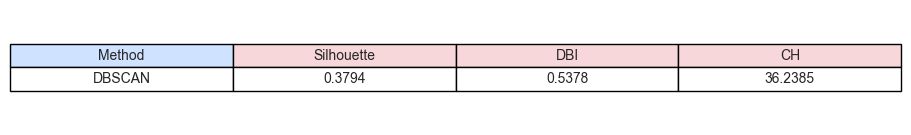

In [42]:
# Filter out noise points for metrics calculation
non_noise_mask = labels != -1
X_non_noise = X[non_noise_mask]
labels_non_noise = labels[non_noise_mask]

# Check if we have enough clusters for metrics
n_clusters = len(np.unique(labels_non_noise))

if n_clusters > 1:
    sil = silhouette_score(X_non_noise, labels_non_noise)
    dbi = davies_bouldin_score(X_non_noise, labels_non_noise)
    ch  = calinski_harabasz_score(X_non_noise, labels_non_noise)

    # === Make table match HCA table orientation ===
    metrics_df = pd.DataFrame({
        "Method": "DBSCAN",
        "Silhouette":     [sil],
        "DBI":            [dbi],
        "CH":             [ch]
    })

    print(f"\nDBSCAN Metrics (excluding {(~non_noise_mask).sum()} noise points):")
    display(metrics_df)

    # === render in your existing table style ===
    import matplotlib.pyplot as plt

    def render_metrics_table(df):
        fig, ax = plt.subplots(figsize=(10, 1.5))
        ax.axis('off')

        # same column colors as before
        col_colors = ["#cfe2ff"] + ["#f8d7da"]*(df.shape[1]-1)

        table = ax.table(
            cellText=df.round(4).values,
            colLabels=df.columns,
            cellLoc='center',
            loc='center',
            colColours=col_colors
        )

        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.15, 1.4)

        plt.show()

    render_metrics_table(metrics_df)

else:
    print(f"Warning: Only {n_clusters} cluster(s) found. Cannot calculate metrics.")

## Cluster Profiling

Average feature values per cluster

In [32]:
df_with_labels = df.copy()
df_with_labels['Cluster'] = labels

# Profile for each cluster (including noise as -1)
cluster_profiles = df_with_labels.groupby('Cluster').mean()
cluster_profiles

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,
-1,17702.893130,11054.083969,15030.969466,5459.381679,5948.328244,2866.961832
0,8906.387205,3444.838384,4735.178451,2083.713805,1498.400673,949.885522
1,41090.428571,2138.000000,3095.571429,1182.571429,741.571429,1062.428571
2,5644.400000,12837.800000,20297.600000,1866.000000,7682.000000,1163.600000


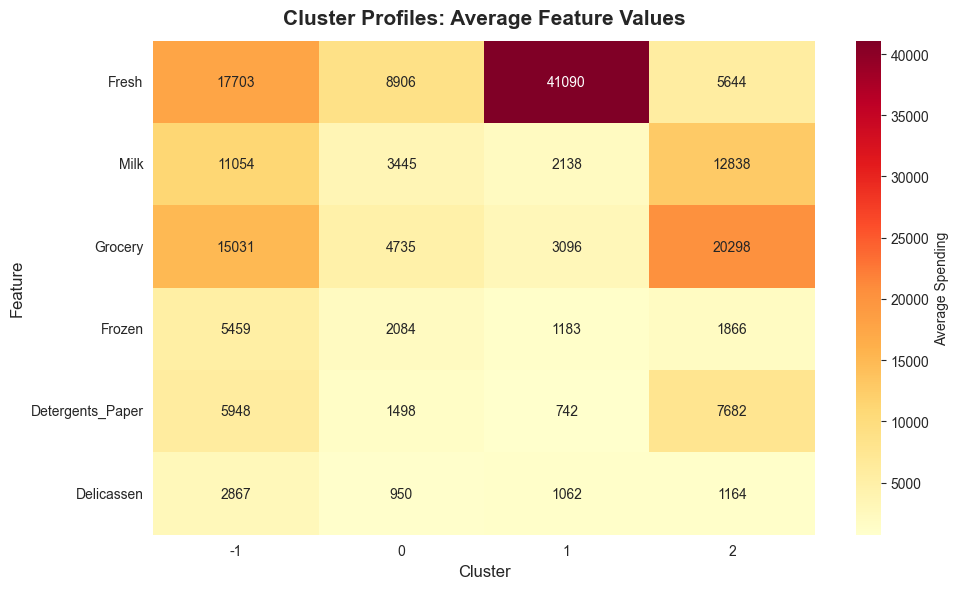

In [33]:
# Visualize cluster profiles as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_profiles.T, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Average Spending'})
plt.title('Cluster Profiles: Average Feature Values', fontsize=15, weight='bold', pad=12)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

## Comparison with Ground Truth Labels

Comparing DBSCAN clusters with the original Channel and Region labels

In [34]:
# Add full data labels
df_full_with_clusters = df_full.copy()
df_full_with_clusters['Cluster'] = labels
df_full_with_clusters['PC1'] = X_pca[:, 0]
df_full_with_clusters['PC2'] = X_pca[:, 1]

### Heatmap Analysis

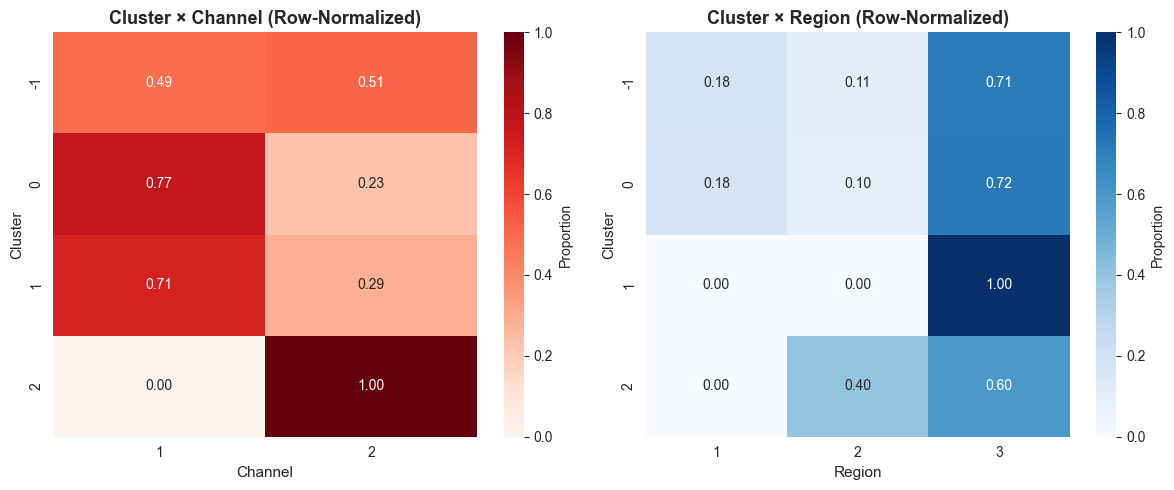

In [35]:
# Channel crosstab
ct_channel = pd.crosstab(
    df_full_with_clusters['Cluster'],
    df_full_with_clusters['Channel'],
    normalize='index'
)

# Region crosstab
ct_region = pd.crosstab(
    df_full_with_clusters['Cluster'],
    df_full_with_clusters['Region'],
    normalize='index'
)

# Side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: Channel ---
sns.heatmap(ct_channel, annot=True, cmap='Reds', fmt='.2f', ax=axes[0],
            cbar_kws={'label': 'Proportion'})
axes[0].set_title('Cluster × Channel (Row-Normalized)', fontsize=13, weight='bold')
axes[0].set_xlabel('Channel', fontsize=11)
axes[0].set_ylabel('Cluster', fontsize=11)

# --- Right: Region ---
sns.heatmap(ct_region, annot=True, cmap='Blues', fmt='.2f', ax=axes[1],
            cbar_kws={'label': 'Proportion'})
axes[1].set_title('Cluster × Region (Row-Normalized)', fontsize=13, weight='bold')
axes[1].set_xlabel('Region', fontsize=11)
axes[1].set_ylabel('Cluster', fontsize=11)

plt.tight_layout()
plt.show()

### External Validation Metrics

**ARI (Adjusted Rand Index):** Measures similarity between two clusterings, adjusted for chance. Range: -1 to 1 (1 = perfect match, 0 = random)

**NMI (Normalized Mutual Information):** Measures mutual information between two clusterings. Range: 0 to 1 (1 = perfect match)

In [36]:
ari_channel = adjusted_rand_score(df_full_with_clusters['Channel'], 
                                   df_full_with_clusters['Cluster'])
ari_region = adjusted_rand_score(df_full_with_clusters['Region'], 
                                  df_full_with_clusters['Cluster'])

nmi_channel = normalized_mutual_info_score(df_full_with_clusters['Channel'], 
                                            df_full_with_clusters['Cluster'])
nmi_region = normalized_mutual_info_score(df_full_with_clusters['Region'], 
                                           df_full_with_clusters['Cluster'])

external_metrics = pd.DataFrame({
    'Ground Truth': ['Channel', 'Region'],
    'ARI': [ari_channel, ari_region],
    'NMI': [nmi_channel, nmi_region]
})

print("External Validation Metrics:")
display(external_metrics)

External Validation Metrics:


,Ground Truth,ARI,NMI
0,Channel,0.131193,0.072817
1,Region,-0.005973,0.013323


## PCA Visualization by Ground Truth

Comparing DBSCAN results with original Channel and Region labels

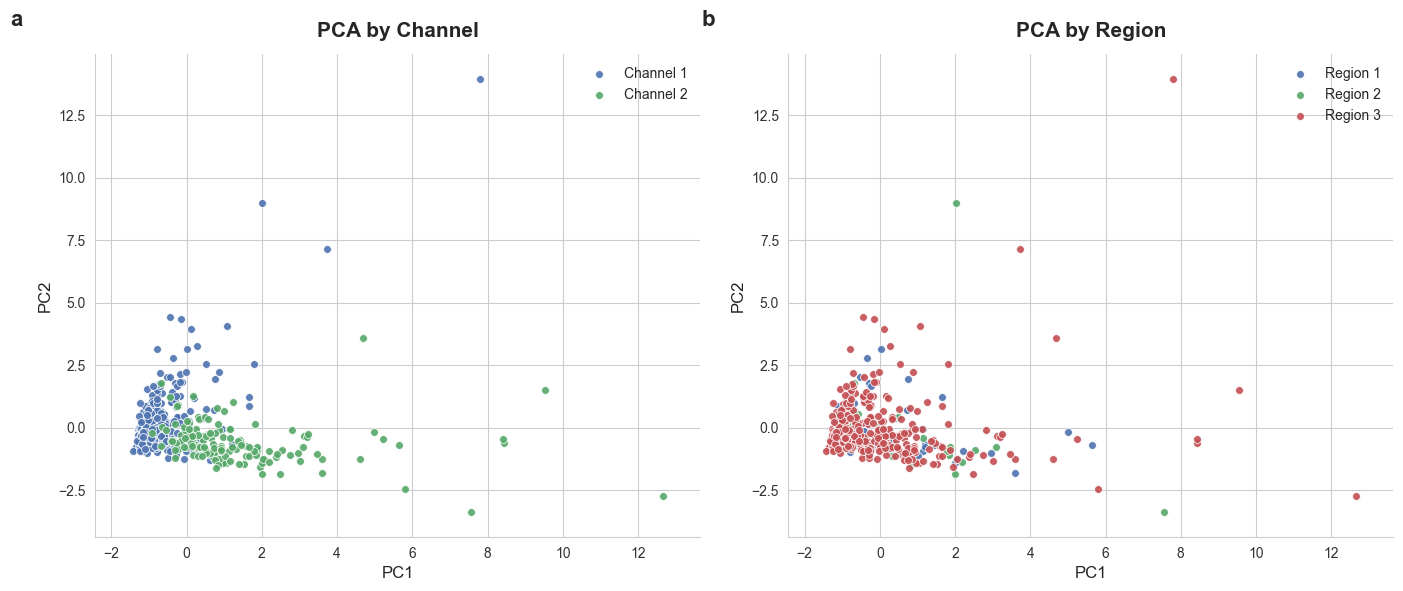

In [ ]:
palette_ns = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974", "#64B5CD"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Shared axis limits
xlim = (X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1)
ylim = (X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1)

# --- Panel A: Channel ---
for idx, ch in enumerate(sorted(df_full_with_clusters['Channel'].unique())):
    subset = df_full_with_clusters[df_full_with_clusters['Channel'] == ch]
    axes[0].scatter(
        subset['PC1'], subset['PC2'],
        s=32, color=palette_ns[idx],
        edgecolor='white', linewidth=0.6,
        alpha=0.9, label=f'Channel {ch}'
    )

axes[0].set_title('PCA by Channel', fontsize=15, weight='bold', pad=12)
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].legend(frameon=False, fontsize=10)

for spine in ['top', 'right']:
    axes[0].spines[spine].set_visible(False)
axes[0].spines['bottom'].set_linewidth(0.8)
axes[0].spines['left'].set_linewidth(0.8)
axes[0].tick_params(colors='#333333', labelsize=10, length=3, width=0.8)

axes[0].text(-0.12, 1.05, 'a', transform=axes[0].transAxes,
             fontsize=16, weight='bold', ha='right', va='bottom')

# --- Panel B: Region ---
for idx, reg in enumerate(sorted(df_full_with_clusters['Region'].unique())):
    subset = df_full_with_clusters[df_full_with_clusters['Region'] == reg]
    axes[1].scatter(
        subset['PC1'], subset['PC2'],
        s=32, color=palette_ns[idx],
        edgecolor='white', linewidth=0.6,
        alpha=0.9, label=f'Region {reg}'
    )

axes[1].set_title('PCA by Region', fontsize=15, weight='bold', pad=12)
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)
axes[1].set_xlabel('PC1', fontsize=12)
axes[1].set_ylabel('PC2', fontsize=12)
axes[1].legend(frameon=False, fontsize=10)

for spine in ['top', 'right']:
    axes[1].spines[spine].set_visible(False)
axes[1].spines['bottom'].set_linewidth(0.8)
axes[1].spines['left'].set_linewidth(0.8)
axes[1].tick_params(colors='#333333', labelsize=10, length=3, width=0.8)

axes[1].text(-0.12, 1.05, 'b', transform=axes[1].transAxes,
             fontsize=16, weight='bold', ha='right', va='bottom')

plt.tight_layout()
plt.show()

## Key Insights

- **Noise handling:** DBSCAN identified noise points (outliers) that don't belong to any cluster
- **Cluster quality:** Internal metrics evaluate the cohesion and separation of clusters
- **Ground truth comparison:** The heatmaps and external metrics show how well DBSCAN clusters align with Channel and Region labels
- **Density-based advantage:** Unlike hierarchical clustering, DBSCAN can find arbitrarily shaped clusters and automatically identifies outliers